In [1]:
import numpy as np
import matplotlib.pyplot as plt
import contextlib as cl
import time

import readdy._internal as api
api.set_logging_level("debug")

In [2]:
sim = api.Simulation()
sim.set_kernel("SingleCPU")

# general definitions
sim.kbt = 1.
sim.periodic_boundary = [False, False, False]

# particle types
diff_coeff = 0.1
particle_radius = 0.5
sim.register_particle_type("R", diff_coeff, particle_radius)
sim.register_particle_type("RA", diff_coeff, particle_radius)
sim.register_particle_type("G", diff_coeff, particle_radius)
sim.register_particle_type("GA", diff_coeff, particle_radius)

# the simulation box
sim.box_size = api.Vec(20., 20., 5.)

# the potential that confines particles
force_const = 100.
origin = np.array([-7.,-7.,-0.1])
extent = np.array([14.,14.,0.2])
consider_particle_radius = False
for ptype in ["R", "RA", "G", "GA"]:
    sim.register_potential_box(ptype, force_const, api.Vec(*origin), api.Vec(*extent), consider_particle_radius)

# reactions
sim.register_reaction_enzymatic(label="activation", catalyst_type="RA", from_type="G", to_type="GA", rate=5., educt_distance=1.)

# add particles
n_rhod = 80
n_gprot = 80
rnd = np.random.uniform
for i in range(n_rhod):
    pos = origin + rnd(size=3) * extent
    sim.add_particle("R", api.Vec(*pos))

for i in range(n_gprot):
    pos = origin + rnd(size=3) * extent
    sim.add_particle("G", api.Vec(*pos))

sim.add_particle("RA", api.Vec(0., 0., 0.))

# define observables and run
numbers_ga = []
traj_handle = sim.register_observable_flat_trajectory(stride=10)
sim.register_observable_n_particles(stride=10, types=["GA"], callback=lambda x: numbers_ga.append(x[0]))
with cl.closing(api.File("./obs.h5", api.FileAction.CREATE, api.FileFlag.OVERWRITE)) as f:
    traj_handle.enable_write_to_file(file=f, data_set_name="traj", chunk_size=1000)
    t1 = time.perf_counter()
    sim.run_scheme_readdy(True) \
        .write_config_to_file(f) \
        .with_reaction_scheduler("UncontrolledApproximation") \
        .configure_and_run(100000, 0.005)
    t2 = time.perf_counter()

print("Simulated", t2 - t1, "seconds")

t1 = time.perf_counter()
api.convert_xyz("./obs.h5", "traj", "./traj.xyz", radii={"R": 0.5, "RA": 0.5, "G": 0.5, "GA": 0.5})
t2 = time.perf_counter()
print("Conversion took", t2 - t1, "seconds")

Simulated 15.105993015999985 seconds
Conversion took 2.4530016709999813 seconds


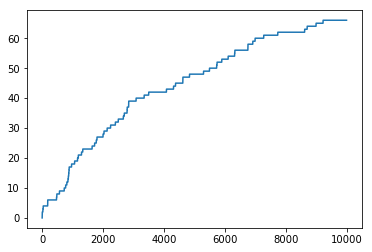

In [4]:
plt.plot(numbers_ga)
plt.show()

### Now do several simulations to average the results

In [5]:
# this function summarizes the complete simulation configuration
def simulate(numbers_ga, sim_idx, n_steps, time_step, stride, with_repulsion=False):
    sim = api.Simulation()
    sim.set_kernel("SingleCPU")
    # general definitions
    sim.kbt = 1.
    sim.periodic_boundary = [False, False, False]
    # particle types
    diff_coeff = 0.1
    particle_radius = 0.5
    sim.register_particle_type("R", diff_coeff, particle_radius)
    sim.register_particle_type("RA", diff_coeff, particle_radius)
    sim.register_particle_type("G", diff_coeff, particle_radius)
    sim.register_particle_type("GA", diff_coeff, particle_radius)
    # the simulation box
    sim.box_size = api.Vec(20., 20., 5.)
    # the potential that confines particles
    force_const = 100.
    origin = np.array([-7.,-7.,-0.1])
    extent = np.array([14.,14.,0.2])
    for ptype in ["R", "RA", "G", "GA"]:
        sim.register_potential_box(ptype, force_const, api.Vec(*origin), api.Vec(*extent), False)
    
    if with_repulsion:
        sim.register_potential_harmonic_repulsion("RA", "R", force_const)
        sim.register_potential_harmonic_repulsion("G", "R", force_const)
        sim.register_potential_harmonic_repulsion("GA", "R", force_const)
        sim.register_potential_harmonic_repulsion("G", "GA", force_const)
        sim.register_potential_harmonic_repulsion("GA", "RA", force_const)
    # reactions
    sim.register_reaction_enzymatic(label="activation", catalyst_type="RA", from_type="G", to_type="GA", rate=5., educt_distance=1.)
    # add particles
    n_rhod = 80
    n_gprot = 80
    rnd = np.random.uniform
    for i in range(n_rhod):
        pos = origin + rnd(size=3) * extent
        sim.add_particle("R", api.Vec(*pos))
    for i in range(n_gprot):
        pos = origin + rnd(size=3) * extent
        sim.add_particle("G", api.Vec(*pos))
    sim.add_particle("RA", api.Vec(0., 0., 0.))
    # define observables and run
    time_idx = 0
    def append_numbers(x):
        nonlocal time_idx
        nonlocal numbers_ga
        nonlocal sim_idx
        numbers_ga[sim_idx, time_idx] = x[0]
        time_idx += 1

    sim.register_observable_n_particles(stride=stride, types=["GA"], callback=append_numbers)
    t1 = time.perf_counter()
    sim.run_scheme_readdy(True) \
        .with_reaction_scheduler("UncontrolledApproximation") \
        .with_skin_size(3.) \
        .configure_and_run(n_steps, time_step)
    t2 = time.perf_counter()
    print("Simulation", sim_idx, "time:", t2 - t1, "seconds")

In [6]:
n_simulations = 10
n_steps = 100000
time_step = 0.005
stride = 10

# no repulsion
numbers_ga_no_rep = np.zeros((n_simulations, n_steps//stride + 1))
times_no_rep = np.linspace(0., n_steps*time_step + time_step, n_steps//stride + 1)

for i in range(n_simulations):
    simulate(numbers_ga_no_rep, i, n_steps, time_step, stride, with_repulsion=False)

# with repulsion
numbers_ga_with_rep = np.zeros((n_simulations, n_steps//stride + 1))
times_with_rep = np.linspace(0., n_steps*time_step + time_step, n_steps//stride + 1)

for i in range(n_simulations):
    simulate(numbers_ga_with_rep, i, n_steps, time_step, stride, with_repulsion=True)

Simulation 0 time: 13.598038440999971 seconds
Simulation 1 time: 13.462683845000015 seconds
Simulation 2 time: 13.508971090999978 seconds
Simulation 3 time: 13.35307803500001 seconds
Simulation 4 time: 13.376094070000022 seconds
Simulation 5 time: 13.42703749200001 seconds
Simulation 6 time: 13.44912307300001 seconds
Simulation 7 time: 13.477806084999997 seconds
Simulation 8 time: 13.579287504999968 seconds
Simulation 9 time: 13.539129339999988 seconds
Simulation 0 time: 14.874887850999983 seconds
Simulation 1 time: 14.91527750299997 seconds
Simulation 2 time: 14.953930911999976 seconds
Simulation 3 time: 14.96331267499994 seconds
Simulation 4 time: 14.89569007800003 seconds
Simulation 5 time: 15.249502845000052 seconds
Simulation 6 time: 15.290771218000032 seconds
Simulation 7 time: 15.145274342999983 seconds
Simulation 8 time: 15.080297094000002 seconds
Simulation 9 time: 15.352369557000088 seconds


In [7]:
# average
# no repulsion
average_numbers_no_rep = np.sum(numbers_ga_no_rep, axis=0) / n_simulations
# with repulsion
average_numbers_with_rep = np.sum(numbers_ga_with_rep, axis=0) / n_simulations

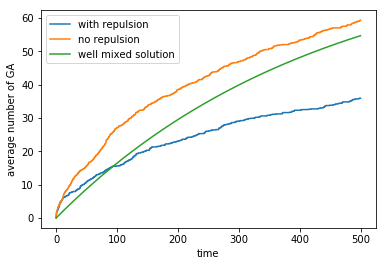

In [8]:
plt.plot(times_with_rep, average_numbers_with_rep, label="with repulsion")
plt.plot(times_no_rep, average_numbers_no_rep, label="no repulsion")
plt.plot(times_no_rep, np.fromiter( map(lambda x: 80.*(1.-np.exp(-0.0023*x)), times_no_rep), np.float ),
         label="well mixed solution")

plt.xlabel("time")
plt.ylabel("average number of GA")
plt.legend(loc="best")
plt.show()

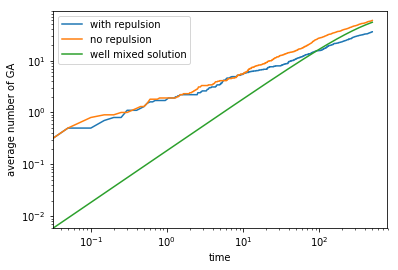

In [9]:
plt.plot(times_with_rep, average_numbers_with_rep, label="with repulsion")
plt.plot(times_no_rep, average_numbers_no_rep, label="no repulsion")
plt.plot(times_no_rep, np.fromiter( map(lambda x: 80.*(1.-np.exp(-0.0023*x)), times_no_rep), np.float ),
         label="well mixed solution")

plt.yscale("log")
plt.xscale("log")
plt.xlabel("time")
plt.ylabel("average number of GA")
plt.legend(loc="best")
plt.show()